In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score
import scipy

In [2]:
class GenericGRU(nn.Module):
    def __init__(self, T_no, H_no, layer_no, in_no, sub_no, device):
        super().__init__()
        
        self.T_no = T_no
        self.H_no = H_no
        self.layer_no = layer_no
        self.in_no = in_no
        self.device = device
        self.sub_no = sub_no
        
        #self.lstm = nn.GRU(self.in_no, self.H_no, self.layer_no, batch_first=True)
        #self.linear = nn.Linear(self.H_no, 1)
        
        self.rnn = nn.ModuleList()
        self.linear = nn.ModuleList()
        for s in range(self.sub_no):
            self.rnn.append(nn.GRU(1, self.H_no, self.layer_no, batch_first=True))
            self.linear.append(nn.Linear(self.H_no, 1))
        
        self.clust_raw = nn.Parameter(torch.zeros(self.sub_no, self.in_no), requires_grad=True)
        
    def forward(self, S, temp):
        T_data = S.shape[0]
        
        W_clust = F.softmax(self.clust_raw/temp, 0)
        sub_out = torch.zeros(T_data, self.sub_no).to(self.device)
        
        for s in range(self.sub_no):
            sub_in = torch.matmul(S, W_clust[s]) #(T_data)
            rnn_out, _ = self.rnn[s](sub_in.reshape(1,-1,1))
            sub_out[:,s] = sub_out[:,s] + self.linear[s](rnn_out.squeeze(0)).flatten()
        
        final = torch.sum(sub_out, 1)
        
        return final, sub_out

In [3]:
base_dir = "/media/hdd01/sklee/"
experiment = "clust4-60"
cell_type = "CA1"
E_neural_file = "Espikes_neural.npz"
I_neural_file = "Ispikes_neural.npz"
V_file = "V_diff.npy"
#V_file = "vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep150_stimseed1.npy"
eloc_file = "Elocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep150_stimseed1.npy"
iloc_file = "Ilocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep150_stimseed1.npy"

E_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
I_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+I_neural_file)
V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)
#V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)[:,:50000].flatten()
V = torch.from_numpy(V)
eloc = np.load(base_dir+cell_type+"_"+experiment+"/data/"+eloc_file)
iloc = np.load(base_dir+cell_type+"_"+experiment+"/data/"+iloc_file)

den_idx = np.unique(eloc[880:1120])
e_idx = np.where(np.isin(eloc[:,0], den_idx) == True)[0]
i_idx = np.where(np.isin(iloc[:,0], den_idx) == True)[0]
e_idx = torch.from_numpy(e_idx)
i_idx = torch.from_numpy(i_idx)

In [4]:
T_train = 149 * 1000 * 50
T_test = 1 * 1000 * 50
T_no = 501
H_no = 15
layer_no = 1
sub_no = 5
in_no = e_idx.shape[0] + i_idx.shape[0]
#in_no = 2200
save_dir = base_dir+cell_type+"_"+experiment+"/"
device = torch.device("cuda")

batch_size = 50000
iter_no = 20000
epoch_no = iter_no*batch_size//T_train 

In [5]:
V_train = V[:T_train].float()
V_test = V[T_train:T_train + T_test].to(device).float()

test_E_neural = E_neural[T_train:T_train+T_test].toarray()
test_I_neural = I_neural[T_train:T_train+T_test].toarray()
train_E_neural = E_neural[:T_train]
train_I_neural = I_neural[:T_train]

test_E_neural = torch.from_numpy(test_E_neural).float().to(device)
test_I_neural = torch.from_numpy(test_I_neural).float().to(device)

batch_no = (T_train - batch_size) * epoch_no
train_idx = np.empty((epoch_no, T_train//batch_size))
for i in range(epoch_no):
    part_idx = np.arange(0, T_train, batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

In [6]:
model = GenericGRU(T_no, H_no, layer_no, in_no, sub_no, device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0025)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

5665


In [7]:
temp_list = np.logspace(-0.5, -4, 50)
temp_count = 0
print(temp_list)

for i in tnrange(iter_no):
    model.train()
    optimizer.zero_grad()
    
    if (i%50 == 49) & (temp_count < 49):
        temp_count += 1
        print(temp)
    temp = temp_list[temp_count] 
    
    
    batch_idx = train_idx[i].long()
    batch_E_neural = train_E_neural[batch_idx : batch_idx+batch_size].toarray()
    batch_I_neural = train_I_neural[batch_idx : batch_idx+batch_size].toarray()
    batch_E_neural = torch.from_numpy(batch_E_neural).float().to(device)
    batch_I_neural = torch.from_numpy(batch_I_neural).float().to(device)
    batch_V = V_train[batch_idx : batch_idx+batch_size].to(device)
    
    V_pred, _ = model(torch.hstack((batch_E_neural[:,e_idx], batch_I_neural[:,i_idx])), temp)
    #V_pred = model(torch.hstack((batch_E_neural, batch_I_neural)))
    
    train_score = explained_variance_score(batch_V.cpu().detach().numpy(), V_pred.cpu().detach().numpy())
            
    #loss = torch.var(V_pred - batch_V)
    loss = torch.mean((V_pred - batch_V)**2)
    loss.backward()
    optimizer.step()
    
    if (i%50 == 49) or (i == 0):
        model.eval()
        test_V_pred, test_sub_out = model(torch.hstack((test_E_neural[:,e_idx], test_I_neural[:,i_idx])), temp)
        #test_V_pred = model(torch.hstack((test_E_neural, test_I_neural)))
                 
        test_score = explained_variance_score(V_test.cpu().detach().numpy(), test_V_pred.cpu().detach().numpy())
        test_mse = torch.mean((V_test-test_V_pred)**2).item()
        
        print(i, test_score, test_mse, train_score, loss.item())


[3.16227766e-01 2.68269580e-01 2.27584593e-01 1.93069773e-01
 1.63789371e-01 1.38949549e-01 1.17876863e-01 1.00000000e-01
 8.48342898e-02 7.19685673e-02 6.10540230e-02 5.17947468e-02
 4.39397056e-02 3.72759372e-02 3.16227766e-02 2.68269580e-02
 2.27584593e-02 1.93069773e-02 1.63789371e-02 1.38949549e-02
 1.17876863e-02 1.00000000e-02 8.48342898e-03 7.19685673e-03
 6.10540230e-03 5.17947468e-03 4.39397056e-03 3.72759372e-03
 3.16227766e-03 2.68269580e-03 2.27584593e-03 1.93069773e-03
 1.63789371e-03 1.38949549e-03 1.17876863e-03 1.00000000e-03
 8.48342898e-04 7.19685673e-04 6.10540230e-04 5.17947468e-04
 4.39397056e-04 3.72759372e-04 3.16227766e-04 2.68269580e-04
 2.27584593e-04 1.93069773e-04 1.63789371e-04 1.38949549e-04
 1.17876863e-04 1.00000000e-04]


<ipython-input-7-b9021c3db517>:5: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


0 0.00843900442123413 0.02957693487405777 0.005347728729248047 0.030939610674977303
0.31622776601683794
49 0.061923086643218994 0.025516493245959282 0.05569422245025635 0.03252177685499191
0.2682695795279726
99 0.1884903907775879 0.022349171340465546 0.15372633934020996 0.023025985807180405
0.22758459260747887
149 0.2716487646102905 0.020684203132987022 0.22820943593978882 0.02098177745938301
0.193069772888325
199 0.28169625997543335 0.019545506685972214 0.21662431955337524 0.023341193795204163
0.16378937069540642
249 0.2866396903991699 0.019416581839323044 0.28856712579727173 0.014729758724570274
0.13894954943731377
299 0.28905028104782104 0.019384149461984634 0.19570493698120117 0.019697874784469604
0.11787686347935872
349 0.290067195892334 0.019321059808135033 0.2693091630935669 0.018106117844581604
0.1
399 0.2942633032798767 0.01954536885023117 0.27383852005004883 0.022900402545928955
0.08483428982440722
449 0.29809999465942383 0.019116215407848358 0.2874886989593506 0.024083830416

KeyboardInterrupt: 

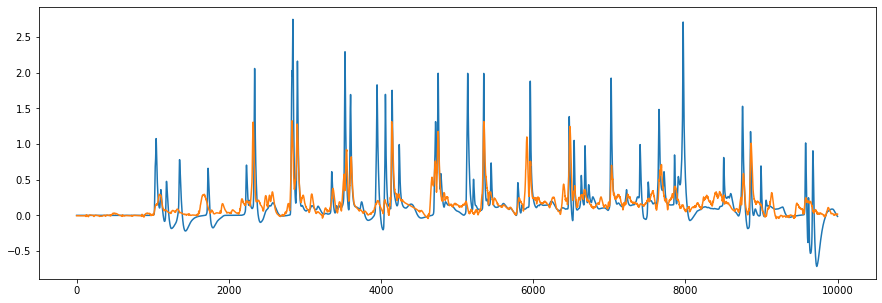

In [8]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy()[16000:26000])
plt.plot(test_V_pred.cpu().detach().numpy()[16000:26000])
#plt.plot(lin_out.flatten().cpu().detach().numpy()[16000:26000])

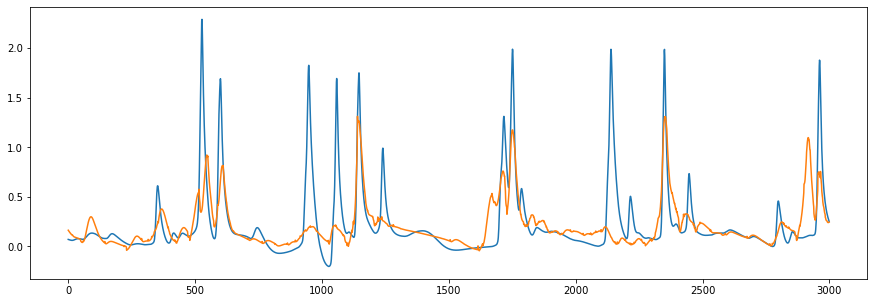

In [9]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy()[16000:26000][3000:6000])
plt.plot(test_V_pred.cpu().detach().numpy()[16000:26000][3000:6000])

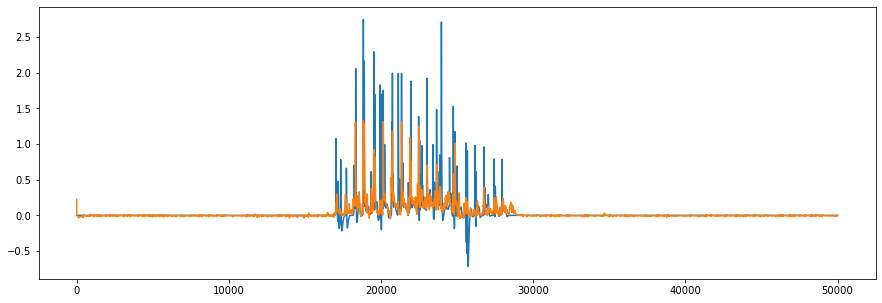

In [10]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy())
plt.plot(test_V_pred.cpu().detach().numpy())

In [11]:
raw = model.clust_raw
syn = torch.zeros(raw.shape[1])
for i in range(syn.shape[0]):
    idx = torch.argmax(raw[:,i])
    syn[i] = idx
    
C_syn = syn.cpu().detach().numpy()
true = eloc[e_idx,0]

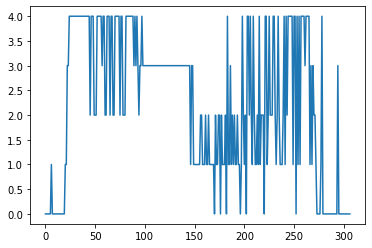

In [12]:
plt.plot(C_syn)

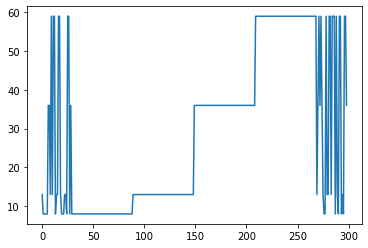

In [13]:
plt.plot(true)